In [1]:
import pandas as pd
import numpy as np
import pickle
from collections import Counter
from ast import literal_eval
from time import time

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'

In [2]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [3]:
from wordcloud import WordCloud

In [155]:
from sklearn.externals import joblib
from sklearn.model_selection import train_test_split
from sklearn.utils import resample, shuffle
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, RandomForestRegressor, AdaBoostRegressor
from sklearn.svm import SVC

from sklearn.base import clone
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from xgboost import XGBClassifier

from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import model_from_json

from keras import utils

Import Traning Data

In [145]:
filename = 'docket_texts/train/DT/basic_cleaned_with_labels.pickle'

#to load
with open(filename, 'rb') as handle:
    NER_df = pickle.load(handle)
    
data = NER_df.copy()

print(data.shape)
data.tail(20)

(3203, 10)


,Original Docket Text,normalized,lemmed,phrases,DT Topics,NoAction,Action,If Action,Action revised,If Action revised
3183,SEALED DOCUMENT placed in vault.(nm) (Entered:...,sealed document placed in vault nm,,,"NoAction, Motions",1.0,N,NaN,N,NaN
3184,Please be advised that Judge Abrams Courtroom ...,please be advised that judge abrams courtroom ...,please advise judge abrams courtroom chamber m...,please advise judge abrams courtroom chamber m...,,0.0,Y,Attorney; Assistant,Y,Attorney; Assistant
3185,MOTION for Andrew John Estes and Simona Gory t...,motion for and to withdraw as attorney for and...,,,Motions,0.0,Y,Attorney,Y,Attorney
3186,MEMO ENDORSEMENT granting 204 MOTION FOR LEAVE...,memo endorsement granting motion for leave to ...,,,"Order, Motions",0.0,Y,Attorney,Y,Attorney
3187,SIXTH REVISED SCHEDULING ORDER: Expert Discove...,sixth revised scheduling order expert discover...,,,"Order, Other Answers, Discovery, Motions",0.0,Y,Attorney; Assistant,Y,Attorney; Assistant
3188,ENDORSED LETTER addressed to Magistrate Judge ...,endorsed letter addressed to magistrate judge ...,,,"Letter and Response, Service of Process, Notic...",0.0,Y,Attorney; Assistant,Y,Attorney; Assistant
3189,ENDORSED LETTER addressed to Magistrate Judge ...,endorsed letter addressed to magistrate judge ...,,,"Letter and Response, Service of Process, Notic...",0.0,Y,Attorney; Assistant,Y,Attorney; Assistant
3190,MOTION for Randall T. Adams to Withdraw as Att...,motion for to withdraw as attorney for plainti...,,,Motions,0.0,Y,Attorney,Y,Attorney
3191,MEMO ENDORSEMENT ON MOTION FOR LEAVE TO WITHDR...,memo endorsement on motion for leave to withdr...,,,Motions,0.0,Y,Attorney,Y,Attorney
3192,MOTION for Joseph P. Fishman to Withdraw as At...,motion for to withdraw as attorney document fi...,,,"Service of Process, Motions",0.0,Y,Attorney; Assistant,Y,Attorney; Assistant


Examine the Data

In [146]:
data.groupby('DT Topics')['DT Topics'].count().index.nunique()

386

In [147]:
sum(data.duplicated())

0

Get Data without DT Topics. This is our model train dataset.

In [148]:
train_data = data[data['DT Topics'] == ''].copy()

In [149]:
print(train_data.shape)
train_data.head()

(156, 10)


,Original Docket Text,normalized,lemmed,phrases,DT Topics,NoAction,Action,If Action,Action revised,If Action revised
77,"STATUS REPORT by LG Capital Funding, LLC (Kehr...",status report by llc kehrli,status report llc kehrli,status_report llc_kehrli,,0.0,Y,Attorney; Assistant,Y,Attorney; Assistant
150,Corporate Disclosure Statement by 5Barz Intern...,corporate disclosure statement by,corporate disclosure statement,corporate_disclosure statement,,0.0,Y,Assistant,Y,Assistant
173,STATUS REPORT and PROPOSED BRIEFING SCHEDULE b...,status report and proposed briefing schedule b...,status report propose brief schedule llc kehrli,status_report propose brief schedule llc_kehrli,,0.0,Y,Attorney; Assistant,Y,Attorney; Assistant
194,"STATUS REPORT by LG Capital Funding, LLC (Kehr...",status report by llc kehrli,status report llc kehrli,status_report llc_kehrli,,0.0,Y,Attorney; Assistant,Y,Attorney; Assistant
234,Proposed Findings of Fact by LG Capital Fundin...,proposed findings of fact by llc kehrli,propose find fact llc kehrli,propose_find fact llc_kehrli,,0.0,Y,Attorney; Assistant,Y,Attorney; Assistant


In [150]:
filename = 'docket_texts/train/DT/basic_cleaned_v2.pickle'

In [151]:
#to save
with open(filename, 'wb') as handle: 
    pickle.dump(train_data, handle, protocol = pickle.HIGHEST_PROTOCOL)

In [152]:
#to load
with open(filename, 'rb') as handle:
    train_cleaned_df = pickle.load(handle)

In [153]:
train_cleaned_df.head()

,Original Docket Text,normalized,lemmed,phrases,DT Topics,NoAction,Action,If Action,Action revised,If Action revised
77,"STATUS REPORT by LG Capital Funding, LLC (Kehr...",status report by llc kehrli,status report llc kehrli,status_report llc_kehrli,,0.0,Y,Attorney; Assistant,Y,Attorney; Assistant
150,Corporate Disclosure Statement by 5Barz Intern...,corporate disclosure statement by,corporate disclosure statement,corporate_disclosure statement,,0.0,Y,Assistant,Y,Assistant
173,STATUS REPORT and PROPOSED BRIEFING SCHEDULE b...,status report and proposed briefing schedule b...,status report propose brief schedule llc kehrli,status_report propose brief schedule llc_kehrli,,0.0,Y,Attorney; Assistant,Y,Attorney; Assistant
194,"STATUS REPORT by LG Capital Funding, LLC (Kehr...",status report by llc kehrli,status report llc kehrli,status_report llc_kehrli,,0.0,Y,Attorney; Assistant,Y,Attorney; Assistant
234,Proposed Findings of Fact by LG Capital Fundin...,proposed findings of fact by llc kehrli,propose find fact llc kehrli,propose_find fact llc_kehrli,,0.0,Y,Attorney; Assistant,Y,Attorney; Assistant


In [154]:
train_cleaned_df['Action revised'].value_counts()
#here we have a problem with imbalanced classes. We need to balance these out before going through the modeling pipeline

Y    142
N     14
Name: Action revised, dtype: int64

Let's waste some time and stare at some wordcloud...

In [156]:
action = train_cleaned_df[train_cleaned_df['Action revised'] == 'Y']['phrases']
noaction = train_cleaned_df[train_cleaned_df['Action revised'] == 'N']['phrases']

In [157]:
%%time
action_words = ''
noaction_words = ''

for val in action:
    text = val.lower()
    tokens = nltk.word_tokenize(text)
    for words in tokens:
        action_words = action_words + words + ' '
        
for val in noaction:
    text = val.lower()
    tokens = nltk.word_tokenize(text)
    for words in tokens:
        noaction_words = noaction_words + words + ' '


Wall time: 792 ms


In [158]:
Counter(action_words.split()).most_common(10) 
#these are kind of wasted words that weren't cleaned out

[('file', 109),
 ('document', 100),
 ('statement', 85),
 ('rule', 75),
 ('inc', 24),
 ('disclosure', 23),
 ('corporate_disclosure', 19),
 ('date', 18),
 ('p', 16),
 ('case', 15)]

In [159]:
Counter(noaction_words.split()).most_common(10) 

[('case', 8),
 ('civil_cover_sheet', 7),
 ('file', 7),
 ('consolidate', 4),
 ('relate', 4),
 ('possibly', 4),
 ('judge', 4),
 ('refer', 4),
 ('cv', 3),
 ('member', 2)]

In [160]:
# Generate a word cloud image
action_wordcloud = WordCloud(width = 600, height = 400).generate(action_words)
noaction_wordcloud = WordCloud(width = 600, height = 400).generate(noaction_words)

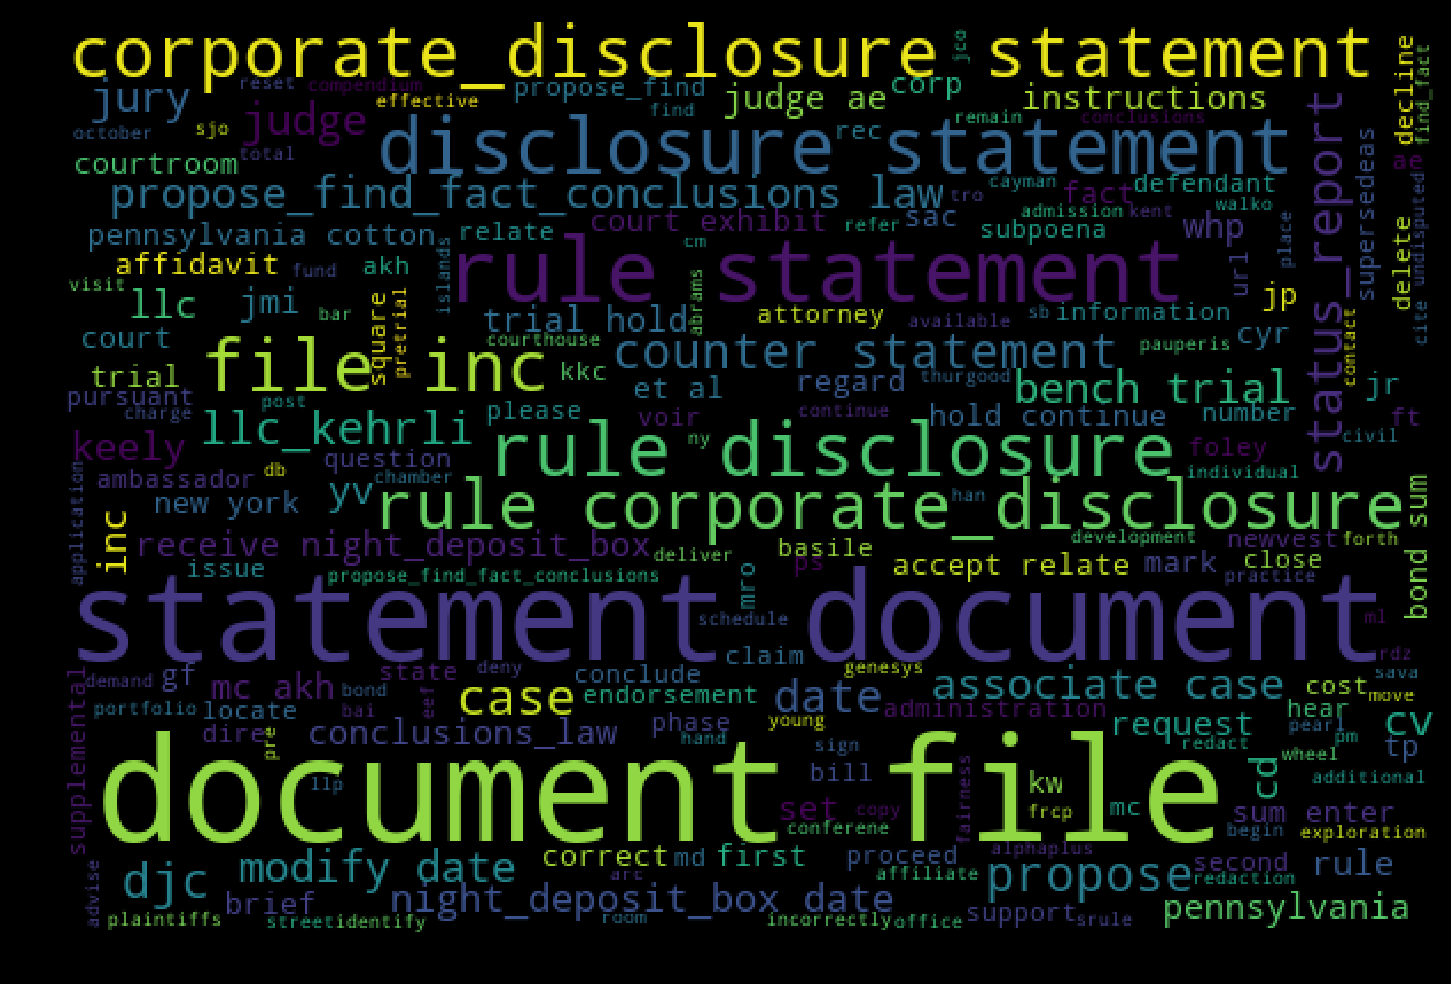

In [161]:
#Action Word cloud
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(action_wordcloud)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

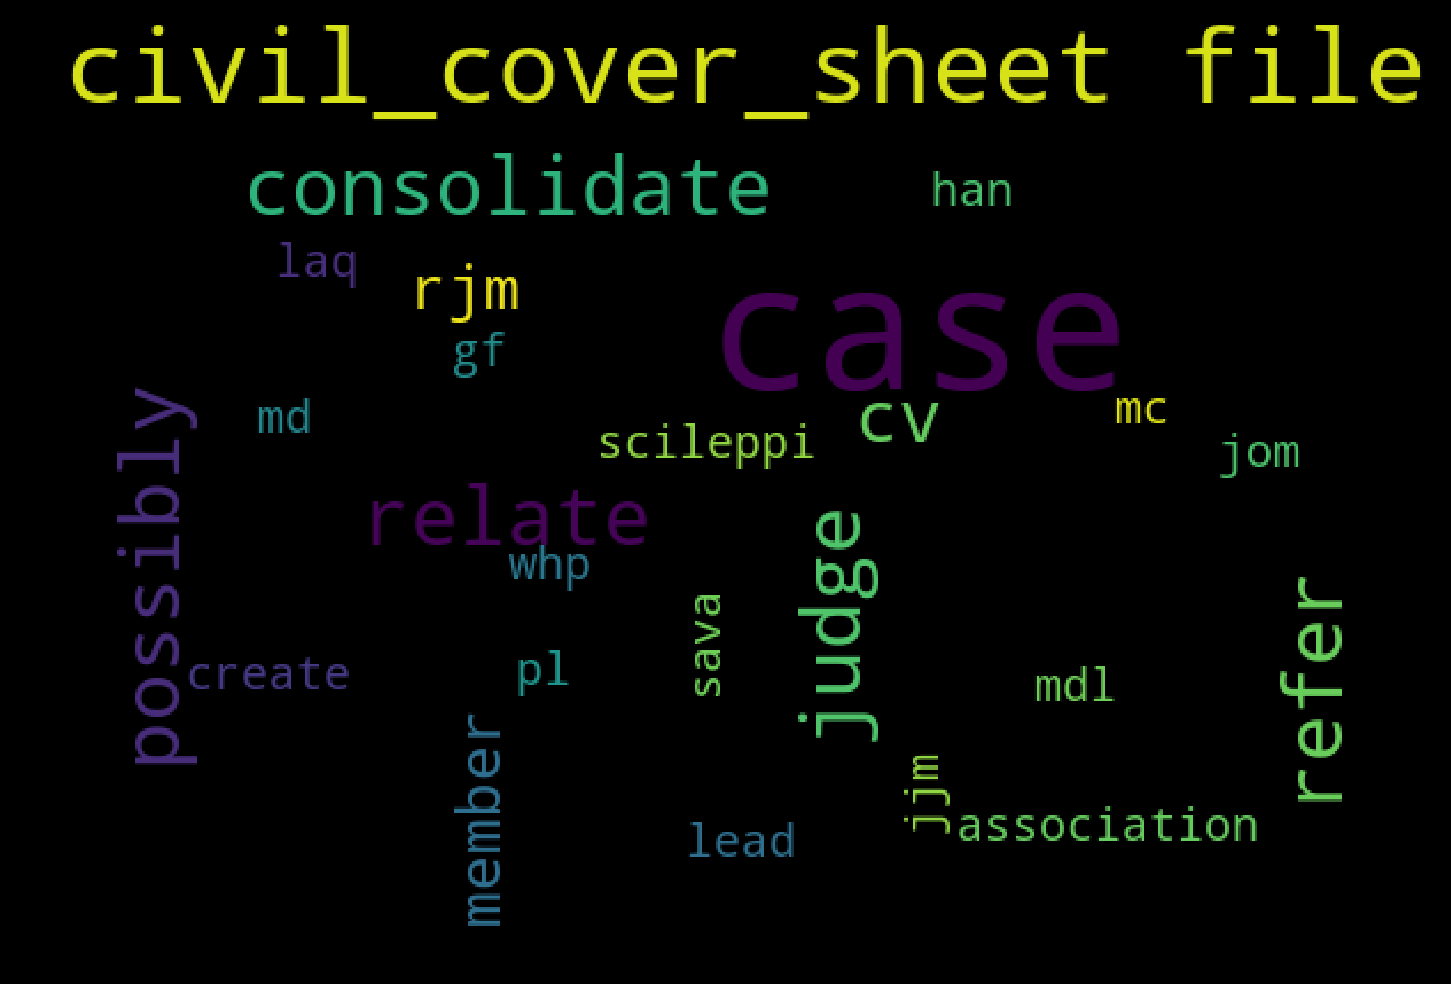

In [162]:
#No-Action Spam Word cloud
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(noaction_wordcloud)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

We need to balance the dataset first, then shuffle

In [163]:
train_cleaned_df['label'] = train_cleaned_df['Action revised'].map({'Y': 1, 'N': 0})

In [164]:
#since my dataset is tiny, i've decided to upsample the minority class
action = train_cleaned_df[train_cleaned_df['label'] == 1]
noaction = train_cleaned_df[train_cleaned_df['label'] == 0]
n = round(action.shape[0] / noaction.shape[0]) #this is about 10 on 2018/9/28
print(n)

noaction_upsampled = resample(noaction, replace = True, n_samples = action.shape[0], random_state = 123)
print(noaction_upsampled.shape)
noaction_upsampled.head()

10
(142, 11)


,Original Docket Text,normalized,lemmed,phrases,DT Topics,NoAction,Action,If Action,Action revised,If Action revised,label
2841,Consolidated Lead Case. (pl) (Entered: 06/29/2...,consolidated lead case pl,consolidate lead case pl,consolidate lead case pl,,0.0,N,NaN,N,NaN,0
465,CASE REFERRED TO Judge Lewis A. Kaplan as poss...,case referred to judge as possibly related to ...,case refer judge possibly relate cv laq,case refer judge possibly relate cv laq,,0.0,N,NaN,N,NaN,0
2347,"CIVIL COVER SHEET filed. (Sava, Matthew) (Ente...",civil cover sheet filed sava,civil cover sheet file sava,civil_cover_sheet file sava,,0.0,N,NaN,N,NaN,0
465,CASE REFERRED TO Judge Lewis A. Kaplan as poss...,case referred to judge as possibly related to ...,case refer judge possibly relate cv laq,case refer judge possibly relate cv laq,,0.0,N,NaN,N,NaN,0
973,"CIVIL COVER SHEET filed. (Scileppi, Laura) (En...",civil cover sheet filed scileppi,civil cover sheet file scileppi,civil_cover_sheet file scileppi,,0.0,N,NaN,N,NaN,0


In [165]:
train_cleaned_df_upsampled = pd.concat([action, noaction_upsampled])
print(train_cleaned_df_upsampled.shape)
train_cleaned_df_upsampled['Action revised'].value_counts()

(284, 11)


N    142
Y    142
Name: Action revised, dtype: int64

In [166]:
#reference: https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/
train_cleaned_df_upsampled_shuffled = shuffle(train_cleaned_df_upsampled, random_state = 4)
feature_choice = 'phrases'
Xtrain, Xtest, ytrain, ytest = train_test_split(train_cleaned_df_upsampled_shuffled[feature_choice], train_cleaned_df_upsampled_shuffled.label, test_size = 0.2, random_state = 10)

### let's make sure everything looks okay

In [168]:
print(Xtrain.shape)
Xtrain.head()

(227,)


2865    bench trial conclude judge bai
688             civil_cover_sheet file
753             civil_cover_sheet file
406             civil_cover_sheet file
2347       civil_cover_sheet file sava
Name: phrases, dtype: object

In [169]:
print(ytrain.shape)
ytrain.head()

(227,)


2865    1
688     0
753     0
406     0
2347    0
Name: label, dtype: int64

In [170]:
print(Xtest.shape)
Xtest.head()

(57,)


940     defendant initial disclosures pursuant rule fr...
1017              case refer judge possibly relate mdl gf
777                            civil_cover_sheet file han
1445              case refer judge possibly relate cv jom
332     rule corporate_disclosure statement document file
Name: phrases, dtype: object

In [171]:
print(ytest.shape)
ytest.head()

(57,)


940     1
1017    0
777     0
1445    0
332     1
Name: label, dtype: int64

Note that we are going to try 3 types of vectorizors
1. Count Vectorizer - this is a bag of words approach
2. TFIDF Vectorizer - this is term frequency, inverse doc frequency approach. suppose to be better than BOW
3. Keras - keras has a lib that does this as well. I think it's more on the TFIDF methodology

In [172]:
#reference: https://www.quora.com/What-is-the-difference-between-TfidfVectorizer-and-CountVectorizer-1

CV_vect = CountVectorizer() #Convert a collection of text documents to a matrix of token counts, bag of words
TV_vect = TfidfVectorizer() #term frequency, inverse document frequency - 

CV_vect.fit(Xtrain)
TV_vect.fit(Xtrain)

#we'll need to save these
joblib.dump(CV_vect, 'Models/CountVectorizerv2.pkl')
joblib.dump(TV_vect, 'Models/TfidfVectorizerv2.pkl')

max_words = len(CV_vect.get_feature_names()) #218 on 2018/9/28
Keras_tokenize = Tokenizer(num_words = max_words, char_level = False)
Keras_tokenize.fit_on_texts(Xtrain)

joblib.dump(Keras_tokenize, 'Models/Keras_tokenizev2.pkl')

['Models/Keras_tokenizev2.pkl']

In [173]:
print('CountVectorizer feature length: {}'.format(len(CV_vect.get_feature_names())))
print('TfidfVectorizer feature length: {}'.format(len(TV_vect.get_feature_names())))

CountVectorizer feature length: 217
TfidfVectorizer feature length: 217


In [175]:
#transform the train and test data into vectors, according to countvectorizer results
CV_vect = joblib.load('Models/CountVectorizerv2.pkl')
Xtrain_CV = CV_vect.transform(Xtrain)
Xtest_CV = CV_vect.transform(Xtest)

TV_vect = joblib.load('Models/TfidfVectorizerv2.pkl')
Xtrain_TV = TV_vect.transform(Xtrain)
Xtest_TV = TV_vect.transform(Xtest)

Keras_tokenize = joblib.load('Models/Keras_tokenizev2.pkl')
Xtrain_Keras = Keras_tokenize.texts_to_matrix(Xtrain)
Xtest_Keras = Keras_tokenize.texts_to_matrix(Xtest)

In [176]:
#print(Xtrain_CV.toarray()[0])
#print(Xtrain_TV.toarray()[0])
print(Xtrain_CV.toarray().shape)
print(Xtrain_TV.toarray().shape)
print(Xtrain_Keras.shape)

(227, 217)
(227, 217)
(227, 217)


### Since we don't need to produce classification, we are going to leave this step for even keras

In [178]:
#this is for keras only... we shouldn't be doing this as we can leverage a softmax activation at the last layer. Also, there's not enough datapoints to get decent neural network results
num_classes = 2
ytrain_Keras = utils.to_categorical(ytrain, num_classes)
ytest_Keras = utils.to_categorical(ytest, num_classes)

In [179]:
print(ytrain_Keras[:10])
print(ytrain[:10])

[[0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]]
2865    1
688     0
753     0
406     0
2347    0
973     0
465     0
688     0
2866    1
973     0
Name: label, dtype: int64


Let's generate some benchmark scores

In [181]:
BMTR_pred = dict()
BMTE_pred = dict()
BMTR_acc_scores = dict()
BMTE_acc_scores = dict()

Multinomial Naive Bayes - Note this is a classifier. we'll use the predict_proba() method

In [182]:
%time
#remember to change 2 things: the id and the model algo
id = 'MNB'
for Xtrain, Xtest, label in zip([Xtrain_CV, Xtrain_TV, Xtrain_Keras], 
                                [Xtest_CV, Xtest_TV, Xtest_Keras], 
                                ['CV', 'TV', 'Keras']):
    model = MultinomialNB()
    model.fit(Xtrain, ytrain)
    BMTR_pred[id + ' ' + label] = model.predict(Xtrain)
    BMTE_pred[id + ' ' + label] = model.predict(Xtest)
    BMTR_acc_scores[id + ' ' + label] = accuracy_score(ytrain, BMTR_pred[id + ' ' + label])
    BMTE_acc_scores[id + ' ' + label] = accuracy_score(ytest, BMTE_pred[id + ' ' + label])

print('updated train acc scores: {}'.format(sorted(BMTR_acc_scores.items(), key = lambda x: x[1], reverse = True)))
print('updated test acc scores: {}'.format(sorted(BMTE_acc_scores.items(), key = lambda x: x[1], reverse = True)))
#CPU time: 
#AWS c5.large time: 0 ns

Wall time: 0 ns
updated train acc scores: [('MNB TV', 0.9823788546255506), ('MNB Keras', 0.9779735682819384), ('MNB CV', 0.9779735682819384)]
updated test acc scores: [('MNB Keras', 1.0), ('MNB TV', 1.0), ('MNB CV', 0.9824561403508771)]


In [185]:
#verifying that predict_proba works
yhat_train = model.predict_proba(Xtrain)
yhat_train[:, 0]

array([2.30225082e-02, 9.99998245e-01, 9.99998245e-01, 9.99998245e-01,
       9.99999598e-01, 9.99999906e-01, 9.99999712e-01, 9.99998245e-01,
       2.26916210e-07, 9.99999906e-01, 3.86898809e-04, 9.99999424e-01,
       9.99999906e-01, 2.47374519e-05, 9.99998245e-01, 1.36123539e-09,
       2.17109037e-09, 6.66422992e-06, 9.99994057e-01, 9.99999589e-01,
       5.08941135e-08, 9.99998245e-01, 5.55968308e-04, 2.77269977e-06,
       9.99998245e-01, 3.97618078e-05, 9.99998245e-01, 3.96444539e-08,
       9.99999598e-01, 9.99999906e-01, 9.99999486e-01, 3.09267947e-09,
       9.99680422e-01, 9.99998245e-01, 4.15904388e-06, 9.99999589e-01,
       9.99994057e-01, 9.99999906e-01, 4.55469470e-06, 9.99940994e-01,
       6.12524060e-05, 9.99999531e-01, 2.53300424e-06, 1.13603487e-04,
       9.99940994e-01, 9.99940994e-01, 9.99998245e-01, 9.99999712e-01,
       2.64296369e-09, 2.15033134e-05, 9.99998245e-01, 9.99999989e-01,
       9.99998245e-01, 9.99998245e-01, 9.99999989e-01, 9.99994057e-01,
      

Bernoulli Naive Bayes - Note this is a classifier. We won't use this for the second round

In [186]:
%time
#remember to change 2 things: the id and the model algo
id = 'BNB'
for Xtrain, Xtest, label in zip([Xtrain_CV, Xtrain_TV, Xtrain_Keras], 
                                [Xtest_CV, Xtest_TV, Xtest_Keras], 
                                ['CV', 'TV', 'Keras']):
    model = BernoulliNB()
    model.fit(Xtrain, ytrain)
    BMTR_pred[id + ' ' + label] = model.predict(Xtrain)
    BMTE_pred[id + ' ' + label] = model.predict(Xtest)
    BMTR_acc_scores[id + ' ' + label] = accuracy_score(ytrain, BMTR_pred[id + ' ' + label])
    BMTE_acc_scores[id + ' ' + label] = accuracy_score(ytest, BMTE_pred[id + ' ' + label])

print('updated train acc scores: {}'.format(sorted(BMTR_acc_scores.items(), key = lambda x: x[1], reverse = True)))
print('updated test acc scores: {}'.format(sorted(BMTE_acc_scores.items(), key = lambda x: x[1], reverse = True)))
#CPU time: 
#AWS c5.large time: 0 ns

Wall time: 0 ns
updated train acc scores: [('MNB TV', 0.9823788546255506), ('MNB Keras', 0.9779735682819384), ('BNB TV', 0.9779735682819384), ('BNB Keras', 0.9779735682819384), ('BNB CV', 0.9779735682819384), ('MNB CV', 0.9779735682819384)]
updated test acc scores: [('MNB Keras', 1.0), ('MNB TV', 1.0), ('BNB Keras', 0.9824561403508771), ('MNB CV', 0.9824561403508771), ('BNB TV', 0.9649122807017544), ('BNB CV', 0.9649122807017544)]


In [187]:
#verifying that predict_proba works
yhat_train = model.predict_proba(Xtrain)
yhat_train[:, 0]

array([6.30753047e-02, 9.99999934e-01, 9.99999934e-01, 9.99999934e-01,
       9.99999981e-01, 9.99999996e-01, 9.99999965e-01, 9.99999934e-01,
       6.44675558e-08, 9.99999996e-01, 2.30364636e-04, 9.99999926e-01,
       9.99999996e-01, 8.17719389e-06, 9.99999934e-01, 5.01223402e-11,
       1.75612655e-10, 9.90430454e-07, 9.99999257e-01, 9.99999948e-01,
       3.11739627e-09, 9.99999934e-01, 1.53484166e-03, 3.15913375e-07,
       9.99999934e-01, 2.38812493e-05, 9.99999934e-01, 1.49341774e-09,
       9.99999981e-01, 9.99999996e-01, 9.99999930e-01, 8.13342026e-11,
       9.99885111e-01, 9.99999934e-01, 4.78139085e-07, 9.99999948e-01,
       9.99999257e-01, 9.99999996e-01, 9.02560662e-07, 9.99992772e-01,
       2.07917483e-05, 9.99999978e-01, 2.35501002e-07, 3.93333888e-05,
       9.99992772e-01, 9.99992772e-01, 9.99999934e-01, 9.99999965e-01,
       8.28142045e-11, 4.95726224e-06, 9.99999934e-01, 9.99999998e-01,
       9.99999934e-01, 9.99999934e-01, 9.99999998e-01, 9.99999257e-01,
      

LogisticRegression (Classifier) - Even though this is a classifier, we can output proba

In [188]:
%time
#remember to change 2 things: the id and the model algo
id = 'LR'
for Xtrain, Xtest, label in zip([Xtrain_CV, Xtrain_TV, Xtrain_Keras], 
                                [Xtest_CV, Xtest_TV, Xtest_Keras], 
                                ['CV', 'TV', 'Keras']):
    model = LogisticRegression()
    model.fit(Xtrain, ytrain)
    BMTR_pred[id + ' ' + label] = model.predict(Xtrain)
    BMTE_pred[id + ' ' + label] = model.predict(Xtest)
    BMTR_acc_scores[id + ' ' + label] = accuracy_score(ytrain, BMTR_pred[id + ' ' + label])
    BMTE_acc_scores[id + ' ' + label] = accuracy_score(ytest, BMTE_pred[id + ' ' + label])

print('updated train acc scores: {}'.format(sorted(BMTR_acc_scores.items(), key = lambda x: x[1], reverse = True)))
print('updated test acc scores: {}'.format(sorted(BMTE_acc_scores.items(), key = lambda x: x[1], reverse = True)))
#CPU time: 
#AWS c5.large time: 0 ns

Wall time: 0 ns
updated train acc scores: [('LR TV', 1.0), ('LR CV', 1.0), ('LR Keras', 1.0), ('MNB TV', 0.9823788546255506), ('MNB Keras', 0.9779735682819384), ('BNB TV', 0.9779735682819384), ('BNB Keras', 0.9779735682819384), ('BNB CV', 0.9779735682819384), ('MNB CV', 0.9779735682819384)]
updated test acc scores: [('MNB Keras', 1.0), ('LR TV', 1.0), ('MNB TV', 1.0), ('LR CV', 1.0), ('LR Keras', 1.0), ('BNB Keras', 0.9824561403508771), ('MNB CV', 0.9824561403508771), ('BNB TV', 0.9649122807017544), ('BNB CV', 0.9649122807017544)]


In [189]:
#verifying that predict_proba works
yhat_train = model.predict_proba(Xtrain)
yhat_train[:, 0]

array([0.14244713, 0.97464149, 0.97464149, 0.97464149, 0.97754783,
       0.98056485, 0.95821386, 0.97464149, 0.02817889, 0.98056485,
       0.03768476, 0.95047697, 0.98056485, 0.03793826, 0.97464149,
       0.00707582, 0.02827282, 0.01589016, 0.94393927, 0.95401433,
       0.00927031, 0.97464149, 0.0706304 , 0.01541516, 0.97464149,
       0.07326622, 0.97464149, 0.01064743, 0.97754783, 0.98056485,
       0.93707617, 0.00722211, 0.37887575, 0.97464149, 0.01564729,
       0.95401433, 0.94393927, 0.98056485, 0.02920115, 0.92036537,
       0.03622271, 0.97717291, 0.04043826, 0.09271968, 0.92036537,
       0.92036537, 0.97464149, 0.95821386, 0.00739133, 0.03434423,
       0.97464149, 0.97003119, 0.97464149, 0.97464149, 0.97003119,
       0.94393927, 0.97717291, 0.97754783, 0.04329401, 0.01879384,
       0.98056485, 0.00559774, 0.97464149, 0.01589016, 0.00926219,
       0.97754783, 0.03822549, 0.01737138, 0.10556568, 0.95821386,
       0.93707617, 0.05876916, 0.10571201, 0.01379472, 0.02373

KNN

In [190]:
%time
#remember to change 2 things: the id and the model algo
id = 'KNN'
for Xtrain, Xtest, label in zip([Xtrain_CV, Xtrain_TV, Xtrain_Keras], 
                                [Xtest_CV, Xtest_TV, Xtest_Keras], 
                                ['CV', 'TV', 'Keras']):
    model = KNeighborsClassifier()
    model.fit(Xtrain, ytrain)
    BMTR_pred[id + ' ' + label] = model.predict(Xtrain)
    BMTE_pred[id + ' ' + label] = model.predict(Xtest)
    BMTR_acc_scores[id + ' ' + label] = accuracy_score(ytrain, BMTR_pred[id + ' ' + label])
    BMTE_acc_scores[id + ' ' + label] = accuracy_score(ytest, BMTE_pred[id + ' ' + label])

print('updated train acc scores: {}'.format(sorted(BMTR_acc_scores.items(), key = lambda x: x[1], reverse = True)))
print('updated test acc scores: {}'.format(sorted(BMTE_acc_scores.items(), key = lambda x: x[1], reverse = True)))
#CPU time: 
#AWS c5.large time: 0 ns

Wall time: 0 ns
updated train acc scores: [('LR TV', 1.0), ('LR CV', 1.0), ('LR Keras', 1.0), ('KNN Keras', 0.9911894273127754), ('KNN TV', 0.986784140969163), ('MNB TV', 0.9823788546255506), ('BNB CV', 0.9779735682819384), ('MNB CV', 0.9779735682819384), ('MNB Keras', 0.9779735682819384), ('BNB TV', 0.9779735682819384), ('BNB Keras', 0.9779735682819384), ('KNN CV', 0.9779735682819384)]
updated test acc scores: [('LR TV', 1.0), ('MNB TV', 1.0), ('LR CV', 1.0), ('KNN TV', 1.0), ('MNB Keras', 1.0), ('LR Keras', 1.0), ('MNB CV', 0.9824561403508771), ('KNN Keras', 0.9824561403508771), ('BNB Keras', 0.9824561403508771), ('BNB CV', 0.9649122807017544), ('BNB TV', 0.9649122807017544), ('KNN CV', 0.8771929824561403)]


In [191]:
#verifying that predict_proba works
yhat_train = model.predict_proba(Xtrain)
yhat_train[:, 0]

array([0. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 0. , 1. , 0. , 1. , 1. ,
       0. , 1. , 0. , 0. , 0. , 1. , 1. , 0. , 1. , 0. , 0. , 1. , 0. ,
       1. , 0. , 1. , 1. , 1. , 0. , 0.8, 1. , 0. , 1. , 1. , 1. , 0. ,
       1. , 0. , 1. , 0. , 0. , 1. , 1. , 1. , 1. , 0. , 0. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 0. , 0. , 1. , 0. , 1. , 0. , 0. ,
       1. , 0. , 0. , 0. , 1. , 1. , 0. , 0. , 0. , 0. , 1. , 0. , 1. ,
       1. , 0. , 0. , 0. , 1. , 0.2, 0. , 1. , 1. , 1. , 0. , 0. , 1. ,
       0. , 1. , 1. , 0. , 1. , 1. , 1. , 1. , 0. , 0. , 1. , 0.2, 0. ,
       1. , 1. , 0. , 0. , 0.2, 1. , 1. , 1. , 1. , 0. , 1. , 1. , 0.2,
       1. , 0. , 0. , 0. , 0. , 1. , 0. , 0. , 0. , 0. , 0. , 1. , 1. ,
       1. , 0. , 0. , 0. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 0. ,
       1. , 0. , 0. , 1. , 0. , 0. , 0. , 1. , 0. , 1. , 1. , 0. , 0. ,
       1. , 1. , 1. , 0. , 0. , 0. , 1. , 1. , 1. , 0. , 1. , 0. , 0. ,
       0. , 0. , 1. , 1. , 1. , 0. , 0. , 0. , 0. , 1. , 1. , 0.

SVM

In [194]:
%time
#remember to change 2 things: the id and the model algo
id = 'SVM'
for Xtrain, Xtest, label in zip([Xtrain_CV, Xtrain_TV, Xtrain_Keras], 
                                [Xtest_CV, Xtest_TV, Xtest_Keras], 
                                ['CV', 'TV', 'Keras']):
    model = SVC(probability = True)
    model.fit(Xtrain, ytrain)
    BMTR_pred[id + ' ' + label] = model.predict(Xtrain)
    BMTE_pred[id + ' ' + label] = model.predict(Xtest)
    BMTR_acc_scores[id + ' ' + label] = accuracy_score(ytrain, BMTR_pred[id + ' ' + label])
    BMTE_acc_scores[id + ' ' + label] = accuracy_score(ytest, BMTE_pred[id + ' ' + label])

print('updated train acc scores: {}'.format(sorted(BMTR_acc_scores.items(), key = lambda x: x[1], reverse = True)))
print('updated test acc scores: {}'.format(sorted(BMTE_acc_scores.items(), key = lambda x: x[1], reverse = True)))
#CPU time: 
#AWS c5.large time: 0 ns

Wall time: 0 ns
updated train acc scores: [('LR TV', 1.0), ('LR CV', 1.0), ('LR Keras', 1.0), ('KNN Keras', 0.9911894273127754), ('KNN TV', 0.986784140969163), ('MNB TV', 0.9823788546255506), ('BNB CV', 0.9779735682819384), ('MNB CV', 0.9779735682819384), ('MNB Keras', 0.9779735682819384), ('BNB TV', 0.9779735682819384), ('BNB Keras', 0.9779735682819384), ('KNN CV', 0.9779735682819384), ('SVM Keras', 0.973568281938326), ('SVM CV', 0.9030837004405287), ('SVM TV', 0.5066079295154186)]
updated test acc scores: [('LR TV', 1.0), ('MNB TV', 1.0), ('LR CV', 1.0), ('KNN TV', 1.0), ('MNB Keras', 1.0), ('LR Keras', 1.0), ('MNB CV', 0.9824561403508771), ('KNN Keras', 0.9824561403508771), ('BNB Keras', 0.9824561403508771), ('BNB CV', 0.9649122807017544), ('BNB TV', 0.9649122807017544), ('SVM Keras', 0.9473684210526315), ('KNN CV', 0.8771929824561403), ('SVM CV', 0.8421052631578947), ('SVM TV', 0.47368421052631576)]


In [195]:
#verifying that predict_proba works
yhat_train = model.predict_proba(Xtrain)
yhat_train[:, 0]

array([5.06475268e-02, 9.82755329e-01, 9.82755329e-01, 9.82755329e-01,
       9.82797489e-01, 9.82797489e-01, 9.82715483e-01, 9.82755329e-01,
       1.84565515e-06, 9.82797489e-01, 2.28467610e-06, 9.82539681e-01,
       9.82797489e-01, 8.55049041e-07, 9.82755329e-01, 2.83904202e-09,
       7.77750324e-07, 1.07291524e-08, 9.58554371e-01, 9.82715483e-01,
       5.20366048e-09, 9.82755329e-01, 1.48707519e-02, 8.46916508e-09,
       9.82755329e-01, 4.35392958e-03, 9.82755329e-01, 6.20591907e-09,
       9.82797489e-01, 9.82797489e-01, 9.82747966e-01, 1.89942477e-09,
       9.18184690e-01, 9.82755329e-01, 9.63506341e-09, 9.82715483e-01,
       9.58554371e-01, 9.82797489e-01, 5.77650375e-07, 8.59183233e-01,
       1.11124384e-06, 9.82776885e-01, 2.05597117e-06, 2.09271754e-02,
       8.59183233e-01, 8.59183233e-01, 9.82755329e-01, 9.82715483e-01,
       2.58750532e-09, 8.69748921e-07, 9.82755329e-01, 9.82707466e-01,
       9.82755329e-01, 9.82755329e-01, 9.82707466e-01, 9.58554371e-01,
      

RandomForest

In [196]:
%time
#remember to change 2 things: the id and the model algo
id = 'RF'
for Xtrain, Xtest, label in zip([Xtrain_CV, Xtrain_TV, Xtrain_Keras], 
                                [Xtest_CV, Xtest_TV, Xtest_Keras], 
                                ['CV', 'TV', 'Keras']):
    model = RandomForestClassifier()
    model.fit(Xtrain, ytrain)
    BMTR_pred[id + ' ' + label] = model.predict(Xtrain)
    BMTE_pred[id + ' ' + label] = model.predict(Xtest)
    BMTR_acc_scores[id + ' ' + label] = accuracy_score(ytrain, BMTR_pred[id + ' ' + label])
    BMTE_acc_scores[id + ' ' + label] = accuracy_score(ytest, BMTE_pred[id + ' ' + label])

print('updated train acc scores: {}'.format(sorted(BMTR_acc_scores.items(), key = lambda x: x[1], reverse = True)))
print('updated test acc scores: {}'.format(sorted(BMTE_acc_scores.items(), key = lambda x: x[1], reverse = True)))
#CPU time: 
#AWS c5.large time: 0 ns

Wall time: 0 ns
updated train acc scores: [('LR TV', 1.0), ('RF Keras', 1.0), ('RF CV', 1.0), ('LR CV', 1.0), ('RF TV', 1.0), ('LR Keras', 1.0), ('KNN Keras', 0.9911894273127754), ('KNN TV', 0.986784140969163), ('MNB TV', 0.9823788546255506), ('BNB CV', 0.9779735682819384), ('MNB CV', 0.9779735682819384), ('MNB Keras', 0.9779735682819384), ('BNB TV', 0.9779735682819384), ('BNB Keras', 0.9779735682819384), ('KNN CV', 0.9779735682819384), ('SVM Keras', 0.973568281938326), ('SVM CV', 0.9030837004405287), ('SVM TV', 0.5066079295154186)]
updated test acc scores: [('LR TV', 1.0), ('MNB TV', 1.0), ('RF Keras', 1.0), ('LR CV', 1.0), ('KNN TV', 1.0), ('MNB Keras', 1.0), ('RF TV', 1.0), ('LR Keras', 1.0), ('RF CV', 0.9824561403508771), ('MNB CV', 0.9824561403508771), ('KNN Keras', 0.9824561403508771), ('BNB Keras', 0.9824561403508771), ('BNB CV', 0.9649122807017544), ('BNB TV', 0.9649122807017544), ('SVM Keras', 0.9473684210526315), ('KNN CV', 0.8771929824561403), ('SVM CV', 0.8421052631578947),

In [197]:
#verifying that predict_proba works
yhat_train = model.predict_proba(Xtrain)
yhat_train[:, 0]

array([0.1, 1. , 1. , 1. , 1. , 1. , 1. , 1. , 0. , 1. , 0. , 1. , 1. ,
       0. , 1. , 0. , 0. , 0. , 1. , 1. , 0. , 1. , 0. , 0. , 1. , 0. ,
       1. , 0. , 1. , 1. , 1. , 0. , 0.1, 1. , 0. , 1. , 1. , 1. , 0. ,
       1. , 0. , 1. , 0. , 0. , 1. , 1. , 1. , 1. , 0. , 0. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 0. , 0. , 1. , 0. , 1. , 0. , 0. ,
       1. , 0. , 0. , 0. , 1. , 1. , 0. , 0. , 0. , 0. , 1. , 0. , 1. ,
       1. , 0. , 0. , 0. , 1. , 0. , 0. , 1. , 1. , 1. , 0. , 0. , 1. ,
       0. , 1. , 1. , 0. , 1. , 1. , 1. , 1. , 0. , 0. , 1. , 0. , 0. ,
       1. , 1. , 0. , 0. , 0.1, 1. , 1. , 1. , 1. , 0. , 1. , 1. , 0.1,
       1. , 0. , 0. , 0. , 0. , 1. , 0. , 0. , 0. , 0. , 0. , 1. , 1. ,
       1. , 0. , 0. , 0. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 0. ,
       1. , 0. , 0. , 1. , 0. , 0. , 0. , 1. , 0. , 1. , 1. , 0. , 0. ,
       1. , 1. , 1. , 0. , 0. , 0. , 1. , 1. , 1. , 0. , 1. , 0. , 0. ,
       0. , 0. , 1. , 1. , 1. , 0. , 0. , 0. , 0. , 1. , 1. , 0.

AdaBoost

In [198]:
%time
#remember to change 2 things: the id and the model algo
id = 'AB'
for Xtrain, Xtest, label in zip([Xtrain_CV, Xtrain_TV, Xtrain_Keras], 
                                [Xtest_CV, Xtest_TV, Xtest_Keras], 
                                ['CV', 'TV', 'Keras']):
    model = AdaBoostClassifier()
    model.fit(Xtrain, ytrain)
    BMTR_pred[id + ' ' + label] = model.predict(Xtrain)
    BMTE_pred[id + ' ' + label] = model.predict(Xtest)
    BMTR_acc_scores[id + ' ' + label] = accuracy_score(ytrain, BMTR_pred[id + ' ' + label])
    BMTE_acc_scores[id + ' ' + label] = accuracy_score(ytest, BMTE_pred[id + ' ' + label])

print('updated train acc scores: {}'.format(sorted(BMTR_acc_scores.items(), key = lambda x: x[1], reverse = True)))
print('updated test acc scores: {}'.format(sorted(BMTE_acc_scores.items(), key = lambda x: x[1], reverse = True)))
#CPU time: 
#AWS c5.large time: 0 ns

Wall time: 0 ns
updated train acc scores: [('LR TV', 1.0), ('RF Keras', 1.0), ('AB TV', 1.0), ('RF CV', 1.0), ('AB Keras', 1.0), ('LR CV', 1.0), ('AB CV', 1.0), ('RF TV', 1.0), ('LR Keras', 1.0), ('KNN Keras', 0.9911894273127754), ('KNN TV', 0.986784140969163), ('MNB TV', 0.9823788546255506), ('BNB CV', 0.9779735682819384), ('MNB CV', 0.9779735682819384), ('MNB Keras', 0.9779735682819384), ('BNB TV', 0.9779735682819384), ('BNB Keras', 0.9779735682819384), ('KNN CV', 0.9779735682819384), ('SVM Keras', 0.973568281938326), ('SVM CV', 0.9030837004405287), ('SVM TV', 0.5066079295154186)]
updated test acc scores: [('LR TV', 1.0), ('MNB TV', 1.0), ('RF Keras', 1.0), ('AB TV', 1.0), ('AB Keras', 1.0), ('LR CV', 1.0), ('KNN TV', 1.0), ('MNB Keras', 1.0), ('AB CV', 1.0), ('RF TV', 1.0), ('LR Keras', 1.0), ('RF CV', 0.9824561403508771), ('MNB CV', 0.9824561403508771), ('KNN Keras', 0.9824561403508771), ('BNB Keras', 0.9824561403508771), ('BNB CV', 0.9649122807017544), ('BNB TV', 0.964912280701754

In [199]:
#verifying that predict_proba works
yhat_train = model.predict_proba(Xtrain)
yhat_train[:, 0]

array([1.03788559e-03, 9.98992383e-01, 9.98992383e-01, 9.98992383e-01,
       9.98992383e-01, 9.98992383e-01, 9.99216423e-01, 9.98992383e-01,
       1.03788559e-03, 9.98992383e-01, 4.92574148e-04, 9.99216423e-01,
       9.98992383e-01, 4.92574148e-04, 9.98992383e-01, 4.92574148e-04,
       1.03788559e-03, 4.92574148e-04, 9.98601502e-01, 9.99216423e-01,
       4.92574148e-04, 9.98992383e-01, 1.03788559e-03, 4.92574148e-04,
       9.98992383e-01, 1.03788559e-03, 9.98992383e-01, 4.92574148e-04,
       9.98992383e-01, 9.98992383e-01, 9.99216423e-01, 4.92574148e-04,
       1.54442555e-03, 9.98992383e-01, 4.92574148e-04, 9.99216423e-01,
       9.98601502e-01, 9.98992383e-01, 4.92574148e-04, 9.98601502e-01,
       4.92574148e-04, 9.98992383e-01, 7.33170244e-04, 1.03788559e-03,
       9.98601502e-01, 9.98601502e-01, 9.98992383e-01, 9.99216423e-01,
       4.92574148e-04, 4.92574148e-04, 9.98992383e-01, 9.98601502e-01,
       9.98992383e-01, 9.98992383e-01, 9.98601502e-01, 9.98601502e-01,
      

XGBoost

In [200]:
%time
#remember to change 2 things: the id and the model algo
id = 'XGB'
for Xtrain, Xtest, label in zip([Xtrain_CV.toarray(), Xtrain_TV.toarray(), Xtrain_Keras], 
                                [Xtest_CV.toarray(), Xtest_TV.toarray(), Xtest_Keras], 
                                ['CV', 'TV', 'Keras']):
    model = XGBClassifier()
    model.fit(Xtrain, ytrain)
    BMTR_pred[id + ' ' + label] = model.predict(Xtrain)
    BMTE_pred[id + ' ' + label] = model.predict(Xtest)
    BMTR_acc_scores[id + ' ' + label] = accuracy_score(ytrain, BMTR_pred[id + ' ' + label])
    BMTE_acc_scores[id + ' ' + label] = accuracy_score(ytest, BMTE_pred[id + ' ' + label])

print('updated train acc scores: {}'.format(sorted(BMTR_acc_scores.items(), key = lambda x: x[1], reverse = True)))
print('updated test acc scores: {}'.format(sorted(BMTE_acc_scores.items(), key = lambda x: x[1], reverse = True)))
#CPU time: 
#AWS c5.large time: 0 ns

Wall time: 0 ns
updated train acc scores: [('XGB TV', 1.0), ('AB CV', 1.0), ('AB Keras', 1.0), ('RF CV', 1.0), ('XGB Keras', 1.0), ('LR TV', 1.0), ('RF Keras', 1.0), ('AB TV', 1.0), ('LR CV', 1.0), ('XGB CV', 1.0), ('RF TV', 1.0), ('LR Keras', 1.0), ('KNN Keras', 0.9911894273127754), ('KNN TV', 0.986784140969163), ('MNB TV', 0.9823788546255506), ('MNB CV', 0.9779735682819384), ('MNB Keras', 0.9779735682819384), ('BNB Keras', 0.9779735682819384), ('KNN CV', 0.9779735682819384), ('BNB CV', 0.9779735682819384), ('BNB TV', 0.9779735682819384), ('SVM Keras', 0.973568281938326), ('SVM CV', 0.9030837004405287), ('SVM TV', 0.5066079295154186)]
updated test acc scores: [('XGB TV', 1.0), ('AB CV', 1.0), ('AB Keras', 1.0), ('KNN TV', 1.0), ('MNB Keras', 1.0), ('XGB Keras', 1.0), ('LR TV', 1.0), ('MNB TV', 1.0), ('RF Keras', 1.0), ('AB TV', 1.0), ('LR CV', 1.0), ('XGB CV', 1.0), ('RF TV', 1.0), ('LR Keras', 1.0), ('RF CV', 0.9824561403508771), ('MNB CV', 0.9824561403508771), ('KNN Keras', 0.982456

c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\pr

In [201]:
#verifying that predict_proba works
yhat_train = model.predict_proba(Xtrain)
yhat_train[:, 0]

array([0.01503849, 0.9877539 , 0.9877539 , 0.9877539 , 0.9877539 ,
       0.9877539 , 0.97351706, 0.9877539 , 0.01516026, 0.9877539 ,
       0.00776976, 0.97351706, 0.9877539 , 0.00776976, 0.9877539 ,
       0.00776976, 0.00739455, 0.00776976, 0.9684637 , 0.97351706,
       0.00776976, 0.9877539 , 0.00756425, 0.00776976, 0.9877539 ,
       0.02009797, 0.9877539 , 0.00776976, 0.9877539 , 0.9877539 ,
       0.9713758 , 0.00776976, 0.3560722 , 0.9877539 , 0.00776976,
       0.97351706, 0.9684637 , 0.9877539 , 0.00776976, 0.9684637 ,
       0.00776976, 0.9877539 , 0.01405913, 0.01132929, 0.9684637 ,
       0.9684637 , 0.9877539 , 0.97351706, 0.00776976, 0.00776976,
       0.9877539 , 0.9684637 , 0.9877539 , 0.9877539 , 0.9684637 ,
       0.9684637 , 0.9877539 , 0.9877539 , 0.00776976, 0.01405913,
       0.9877539 , 0.00776976, 0.9877539 , 0.00776976, 0.00776976,
       0.9877539 , 0.00776976, 0.00776976, 0.00982827, 0.97351706,
       0.9713758 , 0.01405913, 0.01503849, 0.00776976, 0.00739

Keras

In [210]:
def keras_prelim():
    model = Sequential()
    model.add(Dense(512, input_shape = (Xtrain_CV.shape[1], )))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    return model

In [211]:
id = 'Keras'

for Xtrain, Xtest, label in zip([Xtrain_CV.toarray(), Xtrain_TV.toarray(), Xtrain_Keras], 
                                [Xtest_CV.toarray(), Xtest_TV.toarray(), Xtest_Keras], 
                                ['CV', 'TV', 'Keras']):
    batch_size = 10
    epochs = 10
    model = keras_prelim()
    model.fit(Xtrain, ytrain_Keras, batch_size = batch_size, epochs = epochs, verbose = 1, validation_split = 0.1)

    # Evaluate the accuracy of our trained model
    #score = model.evaluate(Xtest, ytest_Keras, batch_size = batch_size, verbose = 1)
    #print('\nTest score (loss value:', score[0])
    #print('Test accuracy:', score[1])

    BMTR_pred[id + ' ' + label] = np.argmax(model.predict(Xtrain), axis = 1)
    BMTE_pred[id + ' ' + label] = np.argmax(model.predict(Xtest), axis = 1)
    BMTR_acc_scores[id + ' ' + label] = accuracy_score(ytrain, BMTR_pred[id + ' ' + label])
    BMTE_acc_scores[id + ' ' + label] = accuracy_score(ytest, BMTE_pred[id + ' ' + label])

print('updated train acc scores: {}'.format(sorted(BMTR_acc_scores.items(), key = lambda x: x[1], reverse = True)))
print('updated test acc scores: {}'.format(sorted(BMTE_acc_scores.items(), key = lambda x: x[1], reverse = True)))

#CPU time: 
#AWS c5.large time: 0 ns

Train on 204 samples, validate on 23 samples
Epoch 1/10
204/204 [==============================] - 1s - loss: 0.3222 - acc: 0.9167 - val_loss: 0.0693 - val_acc: 0.9565
Epoch 2/10
204/204 [==============================] - 0s - loss: 0.0246 - acc: 0.9951 - val_loss: 0.0236 - val_acc: 1.0000
Epoch 3/10
204/204 [==============================] - 0s - loss: 0.0026 - acc: 1.0000 - val_loss: 0.0211 - val_acc: 1.0000
Epoch 4/10
204/204 [==============================] - 0s - loss: 8.6438e-04 - acc: 1.0000 - val_loss: 0.0210 - val_acc: 1.0000
Epoch 5/10
204/204 [==============================] - 0s - loss: 5.7826e-04 - acc: 1.0000 - val_loss: 0.0206 - val_acc: 1.0000
Epoch 6/10
204/204 [==============================] - 0s - loss: 3.8081e-04 - acc: 1.0000 - val_loss: 0.0217 - val_acc: 1.0000
Epoch 7/10
204/204 [==============================] - 0s - loss: 3.6333e-04 - acc: 1.0000 - val_loss: 0.0219 - val_acc: 1.0000
Epoch 8/10
204/204 [==============================] - 0s - loss: 2.7491e-04 - 

In [214]:
#verifying that predict_proba works
yhat_train = model.predict_proba(Xtrain)
yhat_train[:, 0]

 32/227 [===>..........................] - ETA: 0s

array([2.61764711e-04, 9.99933004e-01, 9.99933004e-01, 9.99933004e-01,
       9.99962687e-01, 9.99967098e-01, 9.99937177e-01, 9.99933004e-01,
       1.63834375e-06, 9.99967098e-01, 1.09280336e-04, 9.99909759e-01,
       9.99967098e-01, 3.05824396e-05, 9.99933004e-01, 4.94631593e-07,
       3.09142206e-06, 1.86668531e-05, 9.99868751e-01, 9.99915838e-01,
       9.30916315e-07, 9.99933004e-01, 3.76667507e-04, 7.65507411e-06,
       9.99933004e-01, 2.43526229e-05, 9.99933004e-01, 4.46703922e-07,
       9.99962687e-01, 9.99967098e-01, 9.99874830e-01, 2.53096431e-07,
       8.28146236e-04, 9.99933004e-01, 5.96015070e-06, 9.99915838e-01,
       9.99868751e-01, 9.99967098e-01, 1.17360310e-06, 9.99548852e-01,
       1.85693425e-05, 9.99968529e-01, 4.50465268e-06, 2.71717226e-06,
       9.99548852e-01, 9.99548852e-01, 9.99933004e-01, 9.99937177e-01,
       1.95131562e-07, 4.99768112e-06, 9.99933004e-01, 9.99984026e-01,
       9.99933004e-01, 9.99933004e-01, 9.99984026e-01, 9.99868751e-01,
      

In [215]:
pd.DataFrame({'Train': BMTR_acc_scores, 
              'Test': BMTE_acc_scores})

,Test,Train
AB CV,1.000000,1.000000
AB Keras,1.000000,1.000000
AB TV,1.000000,1.000000
BNB CV,0.964912,0.977974
BNB Keras,0.982456,0.977974
BNB TV,0.964912,0.977974
KNN CV,0.877193,0.977974
KNN Keras,0.982456,0.991189
KNN TV,1.000000,0.986784
Keras CV,1.000000,1.000000


Let's not try to optimize the models yet, as there are plenty of models that are producing 100% accuracy for train and test datasets

Pick a few models, save, and predict the dataset:
1. LR, 
2. AB, 
3. Keras, 
4. XGB

In [216]:
model = LogisticRegression()

model.fit(Xtrain_TV, ytrain)

#make sure we are looking at the right thing
print(accuracy_score(ytrain, model.predict(Xtrain_TV)))
print(accuracy_score(ytest, model.predict(Xtest_TV)))

#to save
model_name = 'Models/BM_LR'
joblib.dump(model, model_name) 

1.0
1.0


['Models/BM_LR']

In [217]:
model = AdaBoostClassifier()

model.fit(Xtrain_TV, ytrain)

#make sure we are looking at the right thing
print(accuracy_score(ytrain, model.predict(Xtrain_TV)))
print(accuracy_score(ytest, model.predict(Xtest_TV)))

#to save
model_name = 'Models/BM_AB'
joblib.dump(model, model_name) 

1.0
0.9824561403508771


['Models/BM_AB']

In [218]:
batch_size = 10
epochs = 10
model = keras_prelim()
model.fit(Xtrain_TV.toarray(), ytrain_Keras, batch_size = batch_size, epochs = epochs, verbose = 1, validation_split = 0.1)

#make sure we are looking at the right thing
print(accuracy_score(ytrain, np.argmax(model.predict(Xtrain_TV.toarray()), axis = 1)))
print(accuracy_score(ytest, np.argmax(model.predict(Xtest_TV.toarray()), axis = 1)))

#to save
model_name = 'Models/BM_Keras.json'
model_weights = 'Models/BM_Keras.h5'
model_json = model.to_json()
with open(model_name, "w") as json_file:
    json_file.write(model_json)
    
model.save_weights(model_weights)

Train on 204 samples, validate on 23 samples
Epoch 1/10
204/204 [==============================] - 0s - loss: 0.4662 - acc: 0.9265 - val_loss: 0.1694 - val_acc: 1.0000
Epoch 2/10
204/204 [==============================] - 0s - loss: 0.0620 - acc: 0.9853 - val_loss: 0.0096 - val_acc: 1.0000
Epoch 3/10
204/204 [==============================] - 0s - loss: 0.0057 - acc: 1.0000 - val_loss: 0.0022 - val_acc: 1.0000
Epoch 4/10
204/204 [==============================] - 0s - loss: 0.0011 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 1.0000
Epoch 5/10
204/204 [==============================] - 0s - loss: 6.3303e-04 - acc: 1.0000 - val_loss: 0.0013 - val_acc: 1.0000
Epoch 6/10
204/204 [==============================] - 0s - loss: 4.4567e-04 - acc: 1.0000 - val_loss: 0.0012 - val_acc: 1.0000
Epoch 7/10
204/204 [==============================] - 0s - loss: 4.0421e-04 - acc: 1.0000 - val_loss: 0.0011 - val_acc: 1.0000
Epoch 8/10
204/204 [==============================] - 0s - loss: 2.8520e-04 - acc:

In [219]:
model = XGBClassifier()

model.fit(Xtrain_TV.toarray(), ytrain)

#make sure we are looking at the right thing
print(accuracy_score(ytrain, model.predict(Xtrain_TV.toarray())))
print(accuracy_score(ytest, model.predict(Xtest_TV.toarray())))

#to save
model_name = 'Models/BM_XGB'
joblib.dump(model, model_name) 

1.0
1.0


c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
c:\users\inves\appdata\local\programs\python\python35\lib\site-packages\sklearn\preprocessing\label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


['Models/BM_XGB']

# BOOKMARK!!!!!!!!!

In [ ]:
def gridsearch(model, param_grid, cvs, X, y, plot = False):

    acc_by_cv = []
    print('selecting best cv parameter:')
    for cv in cvs:
        cloned_model = clone(model, safe = True)
        grid = GridSearchCV(cloned_model, param_grid = param_grid, n_jobs = 4, cv = cv)
        grid.fit(X, y)
        acc_by_cv.append(grid.best_score_)
        print(cv, ': ')
        print(grid.best_score_) #{'ABC': 0.92, 'KNNC': 0.8, 'LR': 0.928, 'MNB': 0.848, 'RFC': 0.944}
        print(grid.best_estimator_)
    
    best_cv = cvs[np.argmax(acc_by_cv)]
    print('\nbest cv: ', best_cv)
    
    cloned_model = clone(model, safe = True)
    grid = GridSearchCV(cloned_model, param_grid = param_grid, n_jobs = 4, cv = best_cv)
    grid.fit(X, y)
    print(grid.best_score_) #{'ABC': 0.92, 'KNNC': 0.8, 'LR': 0.928, 'MNB': 0.848, 'RFC': 0.944}
    print(grid.best_estimator_)
    print(grid.grid_scores_)
    
    if plot:
        plt.plot(cvs, acc_by_cv)
        plt.show()
        
    return grid.best_estimator_, pd.DataFrame(grid.grid_scores_), best_cv

In [ ]:
t0 = time()
cvs = range(2, 30)
RF_dict = {}
param_grid = {'n_estimators': range(5, 105, 5),
              'max_features': ['auto', 'sqrt', 'log2', None]}
for Xtrain, label in zip([Xtrain_Keras, Xtrain_CV, Xtrain_TV], ['Keras', 'CV', 'TV']):
    model = RandomForestClassifier(n_jobs = 4)
    RF_dict['opt model ' + label], RF_dict['summary df ' + label], RF_dict['cv ' + label] = gridsearch(model, param_grid, cvs, Xtrain, ytrain, plot = True)

print('algo elapsed: {} seconds'.format(time() - t0))
#CPU time: 10666.576189994812 seconds
#AWS c5.large time: 

In [ ]:
print('top score was 0.944')
for key in ['CV', 'TV', 'Keras']:
    print('accuracy scores for {} is {}'.format(key, RF_dict['summary df ' + key]['mean_validation_score'].iloc[RF_dict['summary df ' + key]['mean_validation_score'].argmax()]))
    print('parameters for model {} is {}'.format(key, RF_dict['summary df ' + key]['parameters'].iloc[RF_dict['summary df ' + key]['mean_validation_score'].argmax()]))

In [ ]:
t0 = time()
cvs = range(2, 30)
AB_dict = {}
param_grid = {'n_estimators': range(5, 105, 5),
              'learning_rate': [0.01, 0.1, 0.5, 1, 2, 10, 100]}
for Xtrain, label in zip([Xtrain_Keras, Xtrain_CV, Xtrain_TV], ['Keras', 'CV', 'TV']):
    model = AdaBoostClassifier()
    AB_dict['opt model ' + label], AB_dict['summary df ' + label], AB_dict['cv ' + label] = gridsearch(model, param_grid, cvs, Xtrain, ytrain, plot = True)

print('algo elapsed: {} seconds'.format(time() - t0))
#CPU time: 7522.84
#AWS c5.large time: 

In [ ]:
print('top score was 0.944')
for key in ['CV', 'TV', 'Keras']:
    print('accuracy scores for {} is {}'.format(key, AB_dict['summary df ' + key]['mean_validation_score'].iloc[AB_dict['summary df ' + key]['mean_validation_score'].argmax()]))
    print('parameters for model {} is {}'.format(key, AB_dict['summary df ' + key]['parameters'].iloc[AB_dict['summary df ' + key]['mean_validation_score'].argmax()]))

In [ ]:
def keras1(input_shape):
    model = Sequential()
    model.add(Dense(1024, input_shape = (input_shape, )))
    model.add(Activation('relu'))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    
    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    return model

def keras2(optimizer):
    model = Sequential()
    model.add(Dense(512, input_shape = (Xtrain_Keras.shape[1], )))
    model.add(Activation('relu'))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    model.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
    return model

def keras3(optimizer):
    model = Sequential()
    model.add(Dense(512, input_shape = (Xtrain_Keras.shape[1], )))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    model.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
    return model

def keras4(optimizer):
    model = Sequential()
    model.add(Dense(1024, input_shape = (Xtrain_Keras.shape[1], )))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1024))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    model.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
    return model

def keras5(optimizer):
    model = Sequential()
    model.add(Dense(512, input_shape = (Xtrain_Keras.shape[1], )))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    model.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
    return model

In [ ]:
Xtrain = Xtrain_CV.toarray()
param_grid = {'batch_size': [10, 20],
              'epochs': [10, 20]}

model = KerasClassifier(build_fn = keras1(Xtrain.shape[1]), verbose = 1)
grid = GridSearchCV(estimator = model, param_grid = param_grid, n_jobs = 4)
grid_result = grid.fit(Xtrain, ytrain_Keras)
print(grid_result.best_params_)